<a href="https://colab.research.google.com/github/Shehab-7/NLP/blob/main/Toxic%20Comments%20Classification/Toxic_Comment_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Toxic Comments Classification
Objective :  identify and classify toxic online comments

##Data Description
We have a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic 

- severe_toxic

- obscene

- threat

- insult

- identity_hate




##File Descriptions
- train.csv :  the training set, contains comments with their binary labels

- test.csv :  the test set, you must predict the toxicity probabilities for 
these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

- sample_submission.csv :  a sample submission file in the correct format

- test_labels.csv :  labels for the test data; value of -1 indicates it was not used for scoring



##Needed Imports

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter
import random
from termcolor import colored
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

import string, os
from wordcloud import STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


##Reading Datasets

In [2]:
%%capture
if os.path.isfile('/content/data') == False:
  !gdown --id  1mb0c0Z6n4DGYz9iQqJRK9uVsEcuvIra_
  !unzip /content/data.zip -d /content/data
  !rm /content/data.zip

In [3]:
sample_submission = pd.read_csv("/content/data/sample_submission.csv")
test = pd.read_csv("/content/data/test.csv")
test_labels = pd.read_csv("/content/data/test_labels.csv")
train = pd.read_csv("/content/data/train.csv")

In [4]:
test.sample(10)

,id,comment_text
143089,ef2391d057f7ad96,""" \n\n :While I fully understand (and endorse)..."
103498,acc6cf1088a60a17,== Editing Barnstar ==
76658,7fd73e94d036f0da,""" \n\n == Just one observation == \n\n Hello S..."
22697,25e8050a9038da58,after reading this: No violation – It takes fo...
132830,ddf7b737f2ad6967,"""= Delete NAMBLA's Entire Category== \n It is ..."
19376,2088e584faedcb06,Are you a honky?
20735,22b742459a2b76e0,== July 2009 == \n Please stop your disruptiv...
88357,93637dcaa573c857,""" \n :::::::I've submitted it for deletion. I ..."
37625,3e6f2e1410afebbc,== Anarshits == \n\n You suck nigger cock you ...
115691,c11a33674b25d35e,I disambigued stuff \n\n Please check that I ...


In [5]:
sample_submission.sample(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
129237,d80515a741de2b90,0.5,0.5,0.5,0.5,0.5,0.5
52283,56ca2d8093857233,0.5,0.5,0.5,0.5,0.5,0.5
26439,2bfbfd9ee826d225,0.5,0.5,0.5,0.5,0.5,0.5
99194,a586dc65a54f9524,0.5,0.5,0.5,0.5,0.5,0.5
35903,3bad22e61f195445,0.5,0.5,0.5,0.5,0.5,0.5
39692,41e1fc4974af76db,0.5,0.5,0.5,0.5,0.5,0.5
75567,7def9b2ca9410f8a,0.5,0.5,0.5,0.5,0.5,0.5
121889,cb8fd59cbc1468c9,0.5,0.5,0.5,0.5,0.5,0.5
20583,227d560cbc61a150,0.5,0.5,0.5,0.5,0.5,0.5
85264,8e39a73fc85aa1c6,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
test_labels.sample(100)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
14867,18f9a86aac0ded17,-1,-1,-1,-1,-1,-1
132450,dd4ec00eb5b636d0,0,0,0,0,0,0
85651,8ee63ca210922a18,0,0,0,0,0,0
25239,2a1095e15bf00d40,0,0,0,0,0,0
114204,be960faee259a424,0,0,0,0,0,0
...,...,...,...,...,...,...,...
79915,855c3bdb4c1d9b0a,0,0,0,0,0,0
135003,e1a4e1d74d97f464,0,0,0,0,0,0
57244,5f3b891fd2af7470,-1,-1,-1,-1,-1,-1
6506,0ae972e60f0369da,-1,-1,-1,-1,-1,-1


##Text Preprocessing




In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
train.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
62005,a5ea29cdc0360f4c,"""\nAlso note that WP:CANSTYLE#Population state...",0,0,0,0,0,0
63740,aa8bfbdf76a6a693,Use as a reference.,0,0,0,0,0,0
46536,7c56eec02cf9cb41,"""\nOkay, makes sense. I didn't check all your ...",0,0,0,0,0,0
36226,60ca373691771b96,"""::sounds like you a little ill Gorgonzilla, I...",0,0,0,0,0,0
148007,45333dc5489836ca,Nope. I don't really care. I take no part nor ...,0,0,0,0,0,0
21364,3851edfa25327e3c,"""\n I don't think you counted right, because p...",0,0,0,0,0,0
25823,445a7940613c7281,We must know what we want before we do everyth...,0,0,0,0,0,0
37531,643e5d9086e4aaa8,"(ONLY IF YOU REPORTED ME), then you can kiss m...",1,1,1,0,1,0
85501,e4b32922ce502a95,"""\n\n I thought so \n\nRJensen and his sockpup...",0,0,1,0,1,0
67153,b3abb55edfe85dbb,Sinhalese Nagas \nIt is very much founding fac...,0,0,0,0,0,0


In [9]:
train['comment_text'].duplicated().sum()

0

In [10]:
lens = train.comment_text.str.len()

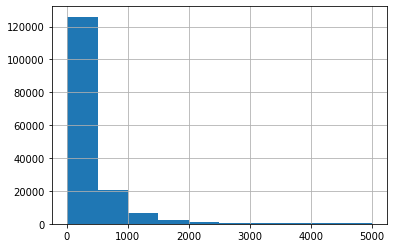

In [11]:
lens.hist()

In [12]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
       
                        "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d][\d]+[:,.\d]')
    return num.sub(r'NUMBER', text)

def clean_text(text):
    text = remove_emoji(text)
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    text = remove_punct(text)
    return text

def process_text(df):    
    df['text_clean'] = df['comment_text'].apply(lambda x: clean_text(x))
    return df

In [14]:
tr = process_text(train)

In [15]:
train['comment_text'][31459]

'"Help me out here, please. This is not easy. \nI need someone to restore the ""helpful"" parts of the talk page\nlinks to archives and vfd\nsummaries of style and reference\n\nAnd bear with me on ""contributor relations"". There\'s a reason Jimbo appointed me to the Mediation Committee. I\'m r-e-a-l-l-y good at mediation! Ask ambi, ask stevertigo. See the talk page, the restart seems to bearing fruit already.\n\nSheesh! Can\'t I have a day (one friggin day!) to try to resolve this? Let\'s see what Patrick has to say. He\'s the one who asked me to look into this. Be patient.  (talk) 11:33, Jun 23, 2005 (UTC)\n\n"'

In [16]:
tr.sample(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean
72543,c220155a2d591adb,"Yes, the source is the ubisoft forums, not sur...",0,0,0,0,0,0,Yes the source is the ubisoft forums not sure ...
53046,8dc4de70c3a1d5ad,"must be sought out. In this case, syntactic me...",0,0,0,0,0,0,must be sought out In this case syntactic meth...
3672,09d0058f248de67b,"""\n\n MediaWiki:Duplicate-defaultsort \n\nDo y...",0,0,0,0,0,0,MediaWikiDuplicatedefaultsort Do you realize ...
28337,4b07d4e012b0d682,I did my randomness 2!\nHey Hadger I have a re...,0,0,0,0,0,0,I did my randomness 2 Hey Hadger I have a real...
42959,728d1cf674a560c0,I couldn't really expand on the third and four...,0,0,0,0,0,0,I couldnt really expand on the third and fourt...
41532,6ec1c5bba4d0e3f6,i am sorry but please get me more friends on r...,0,0,0,0,0,0,i am sorry but please get me more friends on r...
62345,a6d939583e2af035,I agree with the first poster in this topic. I...,0,0,0,0,0,0,I agree with the first poster in this topic Iv...
54533,91c7a4128ccbb8df,(not to be confused with the Governor of the R...,0,0,0,0,0,0,not to be confused with the Governor of the RB...
10266,1b298876a68d3b12,I have implemented most of these suggestions now.,0,0,0,0,0,0,I have implemented most of these suggestions now
128917,b16f29f5d9b3ef96,"""-skinned prick named OlYeller got me banned. ...",0,0,0,0,0,0,skinned prick named OlYeller got me banned He ...


In [17]:
train_copy = tr.copy()
train_copy.drop(['comment_text','id'],inplace=True,axis=1)
train_copy

,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean
0,0,0,0,0,0,0,Explanation Why the edits made under my userna...
1,0,0,0,0,0,0,Daww He matches this background colour Im seem...
2,0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...
3,0,0,0,0,0,0,More I cant make any real suggestions on impr...
4,0,0,0,0,0,0,You sir are my hero Any chance you remember wh...
...,...,...,...,...,...,...,...
159566,0,0,0,0,0,0,And for the second time of asking when your vi...
159567,0,0,0,0,0,0,You should be ashamed of yourself That is a ho...
159568,0,0,0,0,0,0,Spitzer Umm theres no actual article for prost...
159569,0,0,0,0,0,0,And it looks like it was actually you who put ...


##BOW

In [18]:
train_val,test = train_test_split(train_copy,test_size=0.2)

In [19]:
train,val = train_test_split(train_val,test_size=0.2)

In [20]:
vec = CountVectorizer(stop_words='english')
vec.fit(train.text_clean)

CountVectorizer(stop_words='english')

In [21]:
train_vec = vec.transform(train.text_clean)

In [22]:
val_vec = vec.transform(val.text_clean)

In [23]:
test_vec = vec.transform(test.text_clean)

In [24]:
print(train_vec)

  (0, 121913)	1
  (1, 249)	1
  (1, 964)	1
  (1, 1109)	1
  (1, 1848)	1
  (1, 2420)	1
  (1, 4423)	1
  (1, 6793)	2
  (1, 7282)	1
  (1, 7653)	1
  (1, 8526)	1
  (1, 8709)	1
  (1, 10657)	1
  (1, 11324)	1
  (1, 11338)	3
  (1, 11662)	1
  (1, 11822)	1
  (1, 12990)	1
  (1, 12996)	1
  (1, 13161)	1
  (1, 13275)	1
  (1, 13325)	1
  (1, 15521)	1
  (1, 15857)	1
  (1, 16799)	2
  :	:
  (102122, 135963)	1
  (102122, 136170)	1
  (102122, 137084)	1
  (102122, 140233)	1
  (102122, 141054)	1
  (102122, 144271)	1
  (102122, 145160)	1
  (102122, 150737)	1
  (102122, 151514)	1
  (102122, 151541)	1
  (102122, 152454)	1
  (102122, 159466)	2
  (102122, 160562)	1
  (102122, 161133)	1
  (102122, 161586)	1
  (102122, 164655)	3
  (102122, 167141)	1
  (102122, 169482)	1
  (102122, 173448)	1
  (102123, 26746)	1
  (102123, 38205)	1
  (102123, 73133)	1
  (102123, 116267)	1
  (102123, 123627)	1
  (102123, 167141)	1


##Modeling

In [25]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

In [26]:
clf = LogisticRegression(C=12.0)
for label in class_names :
    y = train[label]
    clf.fit(train_vec, y)
    y_pred_X = clf.predict(train_vec)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    test_y_prob = clf.predict_proba(test_vec)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy is 0.9891798206102386


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy is 0.9944577180682308


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy is 0.9878089381536171


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy is 0.999138302455838


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy is 0.9769104226234774
Training accuracy is 0.9939877012259606


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##**Data preprocessing for NN**

In [27]:
train_2 = tr.copy()
train_2

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,More I cant make any real suggestions on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,And for the second time of asking when your vi...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,You should be ashamed of yourself That is a ho...
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,Spitzer Umm theres no actual article for prost...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,And it looks like it was actually you who put ...


In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [30]:
train_2['text_clean'] = train_2['text_clean'].apply(toremove_stopword)

In [31]:
train_2.to_csv('out.csv',index=False)

In [32]:
train_2 = pd.read_csv("out.csv")

In [33]:
lens = train_2.text_clean.str.len()

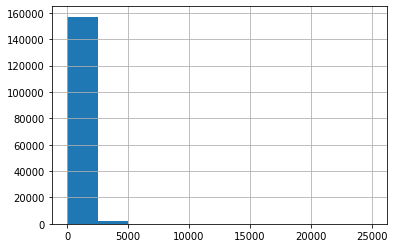

In [34]:
lens.hist()

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_features=1000
y = train_2.drop(['text_clean','id','comment_text'], axis = 1)
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_2['text_clean'].values)
X = tokenizer.texts_to_sequences(train_2['text_clean'].values)
X = pad_sequences(X)

In [36]:
Xtrain, X_test, ytrain, y_test = train_test_split(X,y, test_size = 0.3, random_state =41)

X_train, X_val, y_train, y_val = train_test_split(Xtrain,ytrain, test_size = 0.3, random_state =41)

##LSTM

In [37]:
from tensorflow import keras
from keras import models, layers

embed_dim = 32
lstm_out = 32
model_l = models.Sequential()
model_l.add(layers.Embedding(max_features, embed_dim,input_length = X.shape[1]))
model_l.add(layers.Dropout(0.4))
model_l.add(layers.LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model_l.add(layers.Dense(6,activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.001)
model_l.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model_l.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2500, 32)          32000     
                                                                 
 dropout (Dropout)           (None, 2500, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 40,518
Trainable params: 40,518
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
          print("\nReached 99% accuracy so cancelling training!") 
          self.model.stop_training = True
callbacks = myCallback()

In [39]:
model_l.fit(X_train, y_train, epochs = 5, batch_size=512, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/5
153/153 [==============================] - 1518s 10s/step - loss: 0.2347 - accuracy: 0.9497 - val_loss: 0.1392 - val_accuracy: 0.9936
Epoch 2/5
153/153 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9940
Reached 99% accuracy so cancelling training!
153/153 [==============================] - 1511s 10s/step - loss: 0.1285 - accuracy: 0.9940 - val_loss: 0.1079 - val_accuracy: 0.9932


In [40]:
score = model_l.evaluate(X_test, y_test, verbose=0)

print("%s: %.2f%%" % (model_l.metrics_names[1], score[1]*100))

accuracy: 99.37%


##GRU

In [41]:
from tensorflow import keras
from keras import models, layers
from keras.layers.recurrent import GRU

model_g = models.Sequential()
model_g.add(layers.Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model_g.add(GRU(embed_dim, dropout=0.2, recurrent_dropout=0.5, return_sequences=True))
model_g.add(GRU(embed_dim, dropout=0.4, recurrent_dropout=0.5))

model_g.add(layers.Dense(6,activation='sigmoid'))
model_g.compile(loss='binary_crossentropy', optimizer=adam,metrics=['accuracy'])

In [42]:
his3= model_g.fit(X_train, y_train, batch_size=128, epochs=3, 
          verbose=1, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/3
611/611 [==============================] - 6327s 10s/step - loss: 0.1083 - accuracy: 0.9292 - val_loss: 0.0720 - val_accuracy: 0.9936
Epoch 2/3
611/611 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9942 
Reached 99% accuracy so cancelling training!
611/611 [==============================] - 6448s 11s/step - loss: 0.0709 - accuracy: 0.9942 - val_loss: 0.0705 - val_accuracy: 0.9936


In [43]:
score = model_g.evaluate(X_test, y_test, verbose=0)

print("%s: %.2f%%" % (model_g.metrics_names[1], score[1]*100))

accuracy: 99.45%


##Bidirectional

In [ ]:
from tensorflow.keras.layers import Bidirectional
model_b = models.Sequential()

model_b.add(layers.Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model_b.add(layers.Bidirectional(layers.LSTM(32,return_sequences=True)))
model_b.add(layers.Bidirectional(layers.LSTM(32)))
model_b.add(layers.Dense(32, activation='relu'))
model_b.add(layers.Dense(6, activation='sigmoid'))
model_b.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [45]:
his4= model_b.fit(X_train, y_train, batch_size=512, epochs=3, 
          verbose=1, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/3
153/153 [==============================] - 49s 285ms/step - loss: 0.1294 - accuracy: 0.9325 - val_loss: 0.0741 - val_accuracy: 0.9936
Epoch 2/3
153/153 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9942
Reached 99% accuracy so cancelling training!
153/153 [==============================] - 43s 280ms/step - loss: 0.0702 - accuracy: 0.9942 - val_loss: 0.0700 - val_accuracy: 0.9936


In [ ]:
score = model_b.evaluate(X_test, y_test, verbose=0)

print("%s: %.2f%%" % (model_b.metrics_names[1], score[1]*100))